In [42]:
%pylab inline --no-import-all
import sys
reload(sys)
sys.setdefaultencoding("utf-8") 

<h2 style='text-align:center;'>Python GeoPandas を使った地理情報処理</h2>

<div style='text-align:center;'><a style='margin: 40px 0;' href="https://www.facebook.com/takeshi.osoekawa">Takeshi 'osoken' Osoekawa</a></div>

<h4 style='text-align:center;'> 2015/10/10 第24回GIS学会大会特別セッション</h4>

### 自己紹介

<li class='fragment'>小副川 健 <small style='vertical-align:middle;margin-left:10px;'>[おそえかわ たけし]</small></li>
<li class='fragment'>仕事: <a href='http://www.fujitsu.com/jp/solutions/business-technology/intelligent-data-services/convergence/curation/'>データ分析</a></li>
<li class='fragment'>専門: 計算代数学/計算科学</li>
<li class='fragment'>Python, JavaScript, <small style='vertical-align:middle'>R, C/C++, HTML/CSS...</small></li>

### <a href='https://github.com/geopandas/geopandas'>Geopandas</a> とは

<li class='fragment'>Pandas + 地理空間データの扱い</li>
<li class='fragment'>2013年開発スタート</li>
<li class='fragment'>最新版は <a href='https://github.com/geopandas/geopandas/releases/tag/v0.1.1'>v0.1.1</a> <small style='vertical-align:middle'>(2015/10/10現在)</small></li>
<li class='fragment'>修正BSD三条項ライセンス</li>

### 主な機能

<li class='fragment'>ジオメトリの操作 (Shapely)</li>
<li class='fragment'>データ加工 (Pandas)</li>
<li class='fragment'>地理座標変換 (Pyproj)</li>
<li class='fragment'>ジオコーディング (Geopy)</li>
<li class='fragment'>Shapeファイル、Geo JSON の読み書き (Fionaなど)</li>
<li class='fragment'>PostGIS とのデータのやり取り (SQLAlchemy)</li>
<li class='fragment'>描画 (Matplotlib, Bokeh, Mplleaflet)</li>

### GeoSerise
Geometry の配列

In [47]:
from geopandas import GeoSeries;
gs = GeoSeries.from_file('minato_shinagawa.shp'); # 出典: 地球地図日本(国土地理院技術資料D・1-No.576) より港区・品川区を抜粋

In [48]:
gs

0    (POLYGON ((139.731506347656 35.68159866333006,...
1    (POLYGON ((139.719192504883 35.64186859130862,...
dtype: object

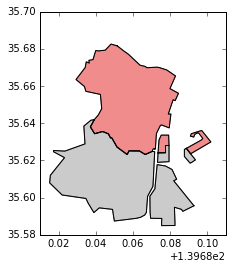

In [49]:
gs.plot();

### GeoDataFrame
Geometry と Features の二次元配列

In [51]:
from geopandas import GeoDataFrame;
gdf = GeoDataFrame.from_file('minato_shinagawa.shp');  # 出典: 地球地図日本(国土地理院技術資料D・1-No.576) より港区・品川区を抜粋

In [52]:
gdf

adm_code  coc f_code                                           geometry  \
0    13103  JPN  FA001  (POLYGON ((139.731506347656 35.68159866333006,...   
1    13109  JPN  FA001  (POLYGON ((139.719192504883 35.64186859130862,...   

            laa       nam     pop salb  soc   ypc  
0     Minato Ku  Tokyo To  235337  UNK  JPN  2014  
1  Shinagawa Ku  Tokyo To  368761  UNK  JPN  2014

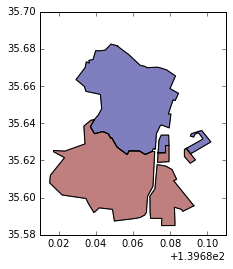

In [53]:
gdf.plot();

### ジオメトリの操作

- 主に Shaply の機能
- Point, Line, Polygon, MultiPoint, MultiLine, MultiPolygon
- buffer, union, intersecton,...

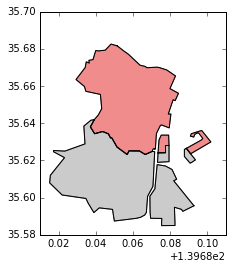

In [54]:
gs.plot();

#### buffer

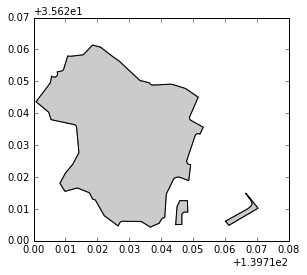

In [57]:
GeoSeries([gs[0].buffer(-0.001)]).plot();

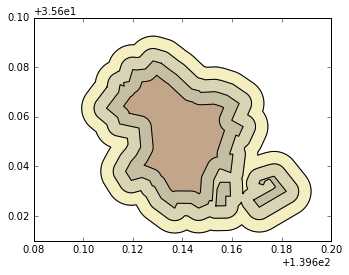

In [58]:
GeoSeries([gs[0].buffer(-0.005),gs[0],gs[0].buffer(0.01),gs[0].buffer(0.005)]).plot(alpha=0.3);

#### union

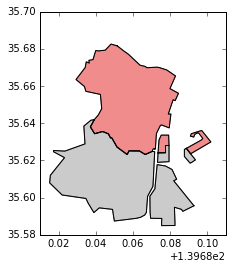

In [59]:
GeoSeries([gs[0],gs[1]]).plot();

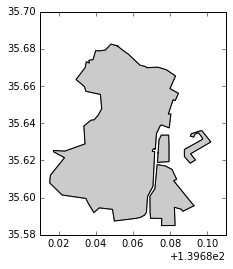

In [60]:
GeoSeries(gs[0].union(gs[1])).plot();

#### intersection

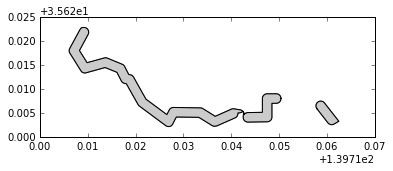

In [61]:
GeoSeries([gs[0].buffer(0.001).intersection(gs[1].buffer(0.001))]).plot();

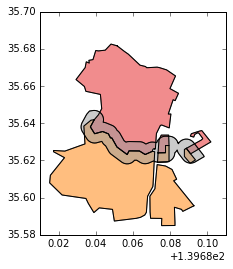

In [62]:
GeoSeries([gs[0],gs[1],gs[0].buffer(0.005).intersection(gs[1].buffer(0.005))]).plot();

### データ加工

- 主に Pandas の機能
- フィルタや集計など

In [63]:
japan_gdf = GeoDataFrame.from_file('gm-jpn-bnd_u_2_1/polbnda_jpn.shp')  # 出典: 地球地図日本(国土地理院技術資料D・1-No.576)

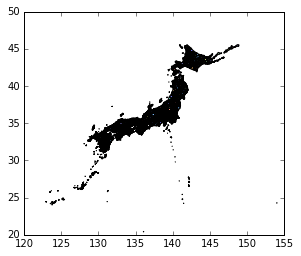

In [64]:
japan_gdf.plot();

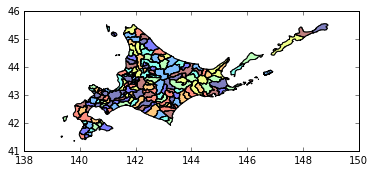

In [66]:
hokkaido=japan_gdf[japan_gdf['nam']=='Hokkai Do']; # 北海道のみ抽出
hokkaido.plot();

In [67]:
hokkaido.area.sum()

9.2903097073086176

In [68]:
hokkaido['pop'].max()

1930496

In [69]:
hokkaido[hokkaido['pop']==hokkaido['pop'].max()]

adm_code  coc f_code                                           geometry  \
0    01100  JPN  FA001  POLYGON ((141.449798583984 43.16333389282232, ...   

           laa        nam      pop salb  soc   ypc  
0  Sapporo Shi  Hokkai Do  1930496  UNK  JPN  2014

### 可視化

- Matplotlib による可視化を標準搭載
- Bokeh (D3.js を使った HTML 生成)
- Mplleaflet (Leflet.js へデータを渡すプラグイン)

#### Matplotlib

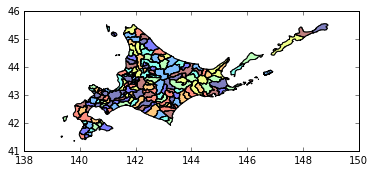

In [70]:
hokkaido.plot();

#### Bokeh

In [71]:
popDict = {laa: max(0,hokkaido[hokkaido['laa']==laa]['pop'].max()) for laa in  hokkaido['laa']};
hokkaido.ix[:,'pop'] = [popDict[laa] for laa in hokkaido['laa']];
county_xs=[];
county_ys=[];

for poly in hokkaido['geometry']:
    lons, lats = zip(*list(poly.exterior.coords))
    county_xs.append(lons)
    county_ys.append(lats)

colors = ["#AAA", "#888", "#666", "#444", "#222", "#000"]

popMax = hokkaido['pop'].max();

county_colors = []
county_names = []
county_pop = []
for pop,laa in zip(hokkaido['pop'],hokkaido['laa']):
    rate = float(pop)/float(popMax);
    idx = min(int(rate*6),5);
    county_colors.append(colors[idx]);
    county_names.append(laa);
    county_pop.append(pop);

from bokeh import plotting;
source = plotting.ColumnDataSource(data = {'x':county_xs,'y':county_ys,'color':county_colors,'name':county_names,'pop':county_pop})


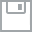
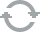
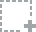
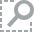
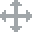
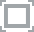
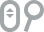
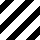
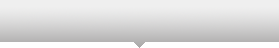
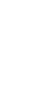
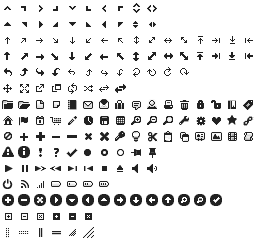
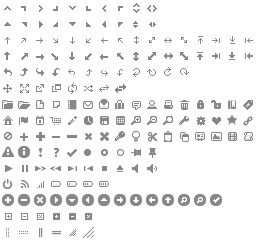
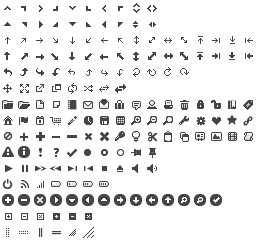
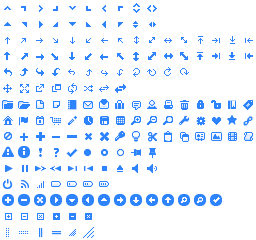
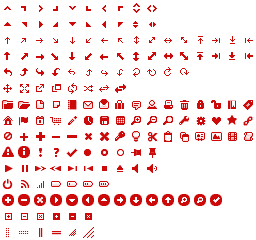
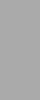
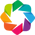
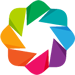

In [72]:
from bokeh.models import HoverTool
from collections import OrderedDict;

plotting.output_notebook();
TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = plotting.figure(toolbar_location="left", plot_width=900, plot_height=700,tools=TOOLS)
p.patches('x', 'y',
    fill_color='color', fill_alpha=0.7,
    line_color="white", line_width=0.5,
    source=source)
hover = p.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([
    ("Name", "@name"),
    ("(人口)", "@pop"),
    ("(Long, Lat)", "($x, $y)"),
])

In [73]:
plotting.show(p)

#### Leaflet (mplleflet)

In [74]:
import mplleaflet;
mplleaflet.display(fig=hokkaido.plot().figure)

### 導入について

<li class='fragment'>Python 2.6, 2.7, 3.3, 3.4, 3.5</li>
<li class='fragment'>いくつか依存パッケージあり</li>
<li class='fragment'>インストールは `$ pip install geopandas`</li>

Windows の場合は、<a href='http://geoffboeing.com/2014/09/using-geopandas-windows/'>このサイト</a>が参考になります。
- Numpy
- GDAL
- Fiona
- Pyproj
- Shapely

の wheel ファイルを入手してこの順にインストールしてから `pip install geopandas`

その他、このノートブックで使ったパッケージは

- Jupyter (ブラウザからインタラクティブに Python 実行: 旧iPython Notebook)
- Bokeh (D3.js 使った可視化)
- Mplleaflet (Leaflet.js 使った可視化)
- <a href='https://github.com/damianavila/RISE'>RISE</a> (reveal.js を使ってスライドを作る Jupyter プラグイン)

## まとめ

<li class='fragment'>GeoPandas を紹介した</li>
<li class='fragment'>Python の既存パッケージの地理関係機能を繋いだもの</li>
<li class='fragment'>Python の豊富なデータ処理が、地理情報ファイルに使える</li>
<li class='fragment'>入出力: Shape ファイル, GeoJSON, PostGIS</li>
<li class='fragment'>可視化へも繋がる（Matplotlib, Bokeh, Leaflet.js）</li>